# Updating the 4 panel z-test figure to use James' bound!


In [5]:
import confirm.outlaw.nb_util as nb_util
import confirm.mini_imprint.bound.normal as jamesbound
nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploration

Our eventual goal is to tune the procedure, using parameter $\lambda$, so that our selected result achieves an upper bound:

$$E[f_\lambda(\mu)] < U(\mu)$$

Where $f(\mu)$ is our error function and $U(\mu)$ is an upper bound on that function.

But first, to help explain this, we will first simplify and assume the value at a few points $f(\mu_i)$ is known exactly. Then, there is the intuitive option to make a confidence interval on these f; but in fact we can do better than this, by allowing ourselves to tune in such a way that a bound on the average $f(\mu_i)$ is enforced. Viewing this averaged test as itself being a statistical test, the result will follow.

In [6]:
delta = 0.01
z_thresh = 1.96
npts = 2
a = -1
b = 0
np.random.seed(9)

mu = np.linspace(a, b, 2 * npts + 1)[1::2]
stepsize = mu[1] - mu[0]
mu

array([-0.75, -0.25])

The test we'll be checking is `z > z_thresh`. For `z_thresh` equal to approximately 1.96, this gives a Type I Error rate of 2.5%.

In [7]:
z_thresh = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)
true_err(0), z_thresh

(DeviceArray(0.025, dtype=float64), DeviceArray(1.95996398, dtype=float64))

But, we can also estimate the Type I Error via simulation. Computing with simulation is much more robust and will
work well for more complex designs. And with just 10,000 simulations, the match between true error and estimated error is reasonable!

In [8]:
# simulating the rejection/type I error
nsims = 100000
samples = np.random.normal(mu[:,None], 1, size=(mu.shape[0], nsims,))
reject = samples > z_thresh
typeI_sum = np.sum(reject, axis=-1)
typeI_est = typeI_sum / nsims
typeI_est, true_err(mu)

(DeviceArray([0.00355, 0.01374], dtype=float64),
 DeviceArray([0.00336453, 0.01355383], dtype=float64))

We can also construct a Clopper-Pearson confidence interval on the Type I Error estimate because the estimate is constructed as a sum of indicator variables.

In [9]:
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
typeI_CI

DeviceArray([0.00046265, 0.0008808 ], dtype=float64)

Now, let's assume the true value of is known exactly at $\mu_i$.

In our paper, we derive an inequality which determines upper bounds on how large $f$ can grow in nearby space.

This bound is based on using Holder's inequality on the likelihood, and thus it is indexed by a parameter q.

Next, we draw a graph showing the maximum value as a function of q.
It turns out that in general, this is a quasi-convex program, and hence can be trivially optimized.
[add graph showing what it looks like as a function of q!]

Here is a plot where the value of q is optimized at every point along the path:
[insert new]. At the endpoints are where it matters most, if we want to think about worst-case Type I Error; 
This worst-case occurs at distance .25, with the choice q = x.
[add plot]

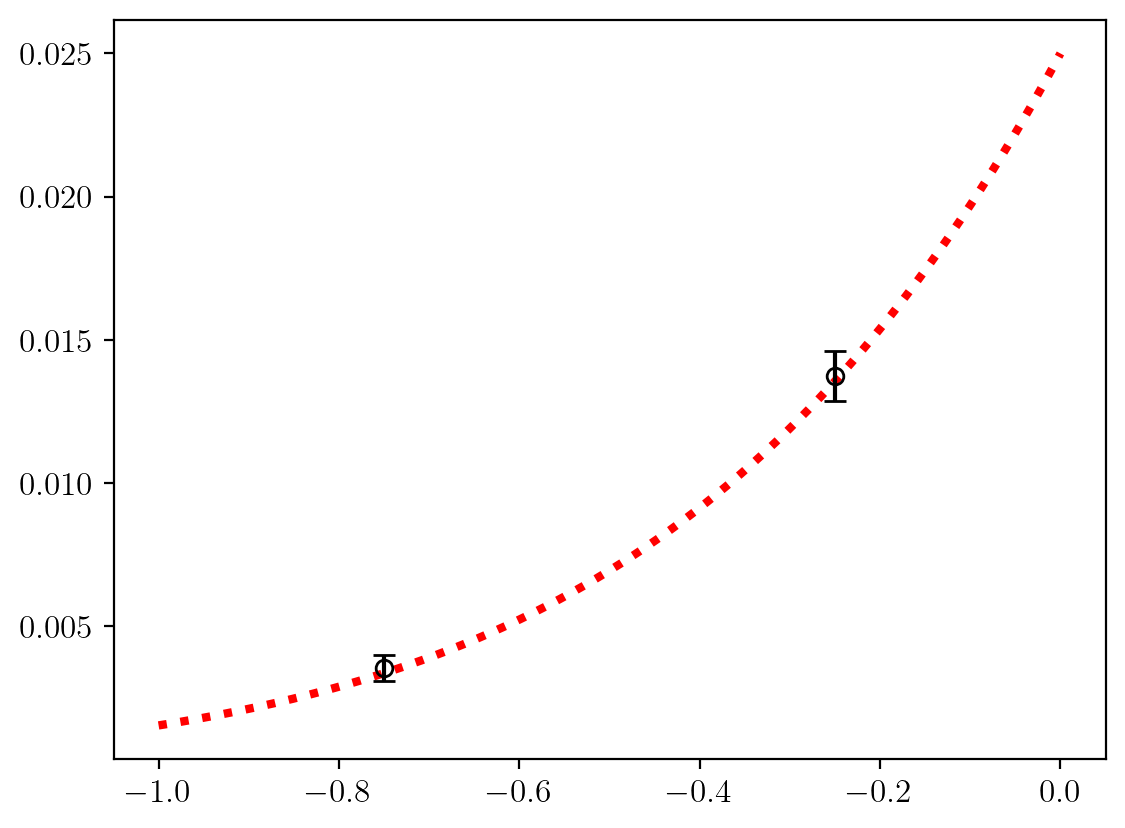

In [10]:
xs = np.linspace(-1, 0, 1000)

plt.plot(xs, true_err(xs), 'r:', linewidth=3)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)
plt.show()



2. The 0th and 1st order CIs.

In [11]:
#uses the following command:
#for i in range(len(mu)):
#    select = closest_mu_idx == i
#    plt.fill_between(xs[select], bound_lo[select], bound_hi[select], color='b', alpha=0.2)
#plt.show()

## A full CSE implementation for Z-test

Below, we use the same tools as above to make the paper figures!

In [12]:
z_thresh_default = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)

def ztest(npts=2, a=-1, b=0, z_thresh=z_thresh_default, delta=0.01, nsims=10000, seed=9, x=None):
    np.random.seed(seed)

    mu = np.linspace(a, b, 2 * npts + 1)[1::2]
    samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
    typeI_sum = np.sum(samples > z_thresh, axis=-1)
    typeI_est = typeI_sum / nsims
    grad_est = np.sum((samples > z_thresh) * (samples - mu[:, None]), axis=-1) / nsims

    typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
    grad_CI = np.sqrt((1 / delta) / nsims)
    hess_bound = 1.0
    
    if x is None:
        x = mu
    closest_mu_idx = np.abs(x[:, None] - mu[None, :]).argmin(axis=-1)

    v = x - mu[closest_mu_idx]
    grad_bounds = np.array([
        v * (grad_est[closest_mu_idx] + grad_CI),
        v * (grad_est[closest_mu_idx] - grad_CI)
    ])
    max_1st_order = np.max(grad_bounds, axis=0)
    min_1st_order = np.min(grad_bounds, axis=0)

    # NOTE: min_2nd_order = -max_2nd_order
    max_2nd_order = 0.5 * hess_bound * v ** 2

    full_max_bound = (typeI_est + typeI_CI)[closest_mu_idx] + max_1st_order + max_2nd_order
    full_min_bound = (typeI_est - typeI_CI)[closest_mu_idx] + min_1st_order - max_2nd_order
    
    return dict(
        mu=mu, 
        typeI_true=true_err(mu), 
        typeI_est=typeI_est, 
        typeI_CI=typeI_CI, 
        grad_est=grad_est, 
        grad_bound=grad_CI, 
        hess_bound=hess_bound,
        closest_mu_idx=closest_mu_idx,
        max_1st_order=max_1st_order,
        min_1st_order=min_1st_order,
        max_2nd_order=max_2nd_order,
        full_max_bound=full_max_bound,
        full_min_bound=full_min_bound
    )

## Figures!

In [13]:
def set_domain(skipx=False, skipy=False):
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel("$\mu$")
        plt.xticks(np.linspace(-1, 0, 6))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        yticks = np.linspace(0, 0.025, 6)
        plt.yticks(
            yticks,
            labels=[f"{(yv * 100):.1f}" for yv in yticks],
            rotation=45,
            ha="right",
        )
        plt.ylabel("\% Type I error")
    plt.axvline(x=0, color="k", linewidth=2, linestyle="-")
    plt.axhline(y=0.025, color="k", linewidth=2, linestyle="-")
    plt.xlim([-1.02, 0.05])
    plt.ylim([-0.001, 0.028])

def plot_power_pts(mu, t1_est, t1_CI=None):
    if t1_CI is None:
        plt.plot(mu, t1_est, "o")
    else:
        plt.errorbar(
            mu,
            t1_est,
            yerr=t1_CI,
            ecolor="k",
            fmt="o",
            capsize=4,
            markeredgecolor="k",
            markerfacecolor="none",
        )

STARTING NEW WORK RIGHT HERE! THIS IS THE SPOT WHERE WE BEGIN!


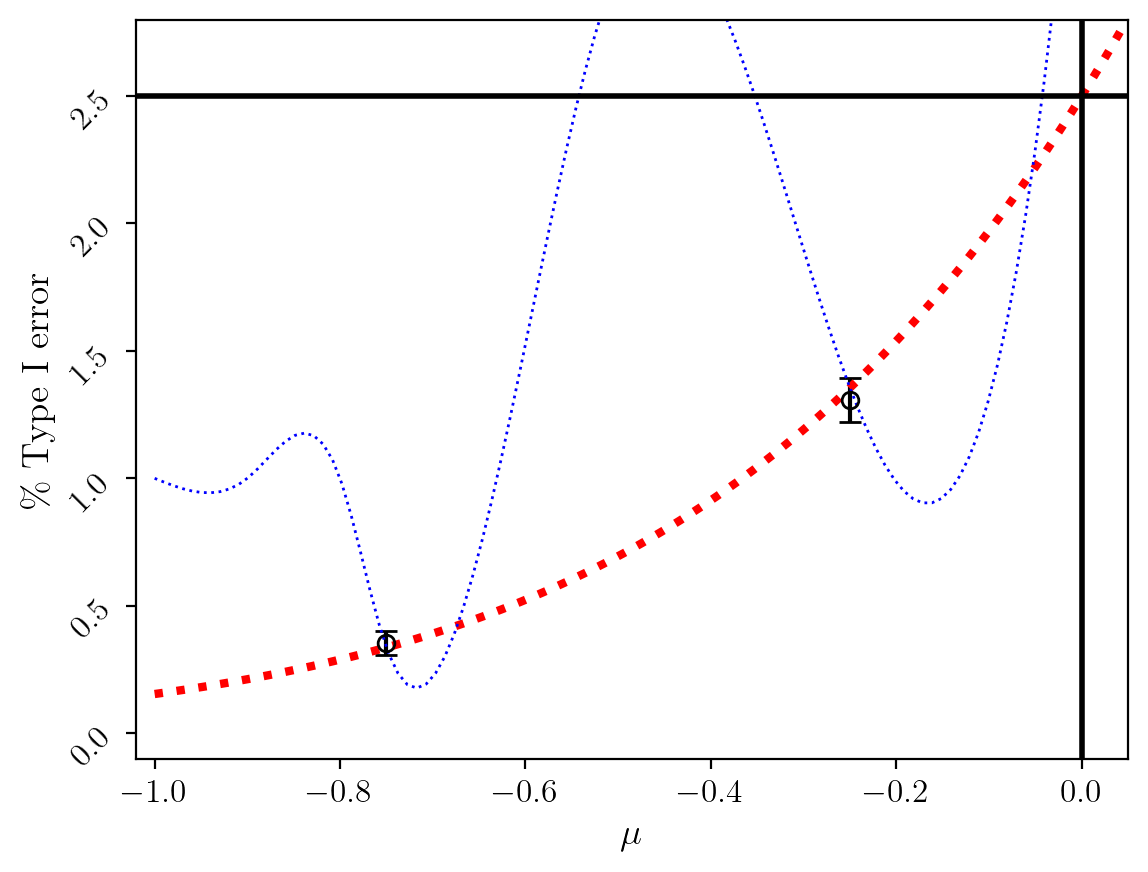

In [14]:
#FIGURE 3. KEEP THIS!
def fig1(include_ptwise_error, **kwargs):
    z = ztest(nsims=int(1e5))

    if include_ptwise_error:
        plot_power_pts(mu, z['typeI_est'], z['typeI_CI'])
    else:
        plot_power_pts(mu, z['typeI_true'])

    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    mu_dense01 = np.linspace(0, 1, 100)
    pow_dense01 = true_err(mu_dense01)
    plt.plot(mu_dense10, pow_dense10, "r:", linewidth=3)
    plt.plot(mu_dense01, pow_dense01, "r:", linewidth=3)

    mu_bad = np.append(z['mu'], [-1.1, -1.0, -0.9, -0.8, -0.5, 0.0])
    t1_bad = np.append(z['typeI_true'], [0.01, 0.01, 0.01, 0.01, 0.03, 0.04])
    interp_f = scipy.interpolate.interp1d(mu_bad, t1_bad, kind="cubic")
    plt.plot(mu_dense10, interp_f(mu_dense10), "b:", linewidth=1)
    set_domain(**kwargs)
fig1(True)

Figure 3 on my list above, Figure 4 below. 
Figure 4 demonstrates the bound for several values of q, centering at mu = -.25


In [221]:
#Bounds for a fixed list of q's
boundpoint=-.25
ystart = true_err(boundpoint)
qlist = 2**np.linspace(9,4,6)
vlist = np.linspace(0,.25,2000)
outputs = np.zeros(shape = (len(qlist), len(vlist)))
for i in range(len(qlist)):
    for j in range(len(vlist)):
        outputs[i,j] = jamesbound.tilt_bound_fwd( qlist[i],1,vlist[j],ystart)
qlist

array([512., 256., 128.,  64.,  32.,  16.])

In [222]:
# What is the optimal q for each v in vlist?
qsolve = jamesbound.ForwardQCPSolver(scale=1)
optqs = qsolve.solve(vlist,true_err(boundpoint))
optbound = jamesbound.tilt_bound_fwd(optqs,1,vlist,ystart)
# We observe that the optimal q ranges from 250 down to 10. It can go much below this for smaller ranges of q, as well.

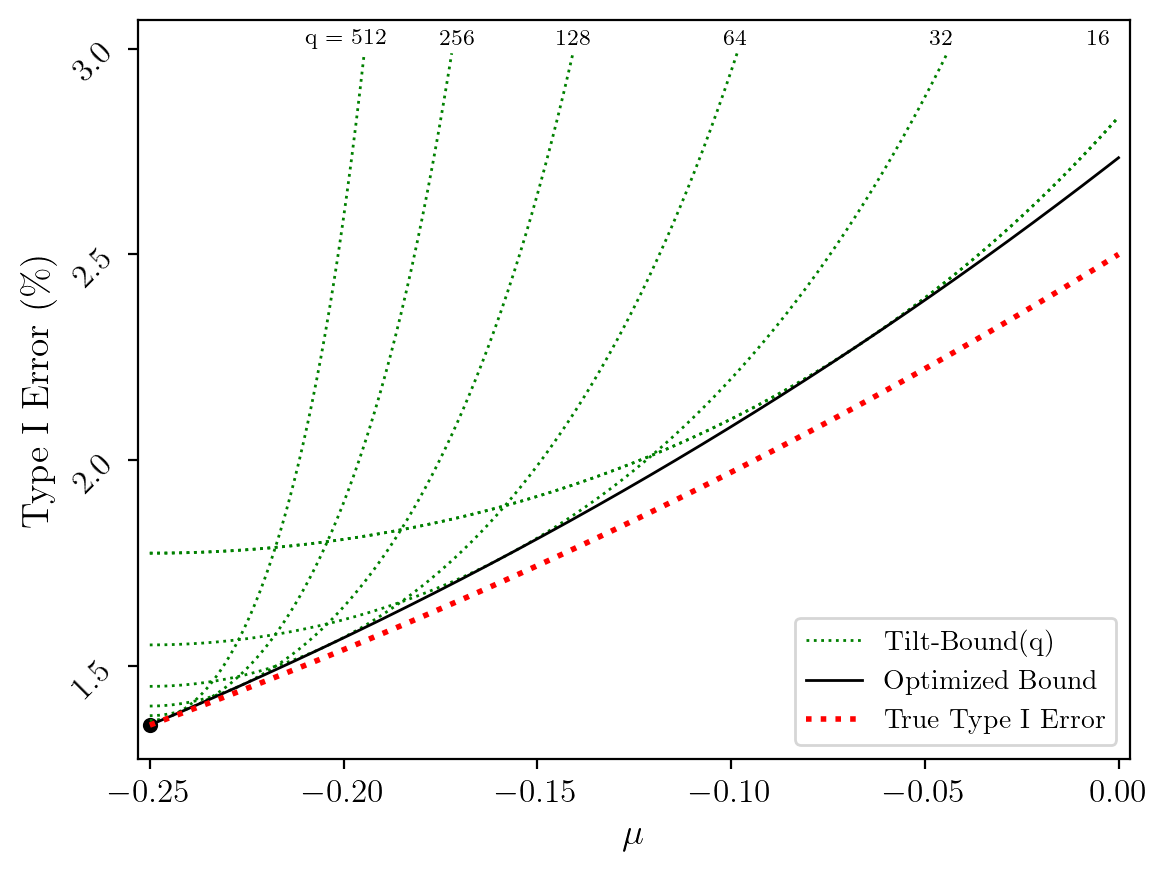

In [223]:
x = np.linspace(-.25, 0, 1000)
z = ztest(delta=0.05, x = x, nsims=int(1e5))
#linestylelist = ['--' , ':' , '--' , ':', '--' , ':']
#colorlist = ['g' , 'k']
linestylelist = [':' , ':' , ':' , ':', ':' , ':']
colorlist = ['g']
mu_dense10 = np.linspace(-.25, 0, 100)
pow_dense10 = true_err(mu_dense10)
vadjust = vlist - np.repeat(0.25,len(vlist))
#Plotting for 6 different choices of q, ranging from 2^4 to 2^9
for i in range(len(qlist)):
    filter = outputs[i] < .0299
    #colorlist[int(i / 3)]
    plt.plot(vadjust[filter], outputs[i,filter], "g", linewidth=1, linestyle = linestylelist[i])
plt.plot(vadjust[filter], outputs[i,filter], "g", linewidth=1, linestyle = linestylelist[i], label = 'Tilt-Bound(q)')
#Now plotting the optimal
filter = optbound < .3
plt.plot(vadjust[filter],optbound[filter],"k",linewidth=1, label = "Optimized Bound")
#Plotting the true function in red
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=2, label = "True Type I Error")
leg = plt.legend(loc='lower right',fontsize = 10)
plt.text(-.21,.0301,'q = 512',fontsize = 8)
plt.text(-.175,.0301,'256',fontsize = 8)
plt.text(-.145,.0301,'128',fontsize = 8)
plt.text(-.102,.0301,'64',fontsize = 8)
plt.text(-.049,.0301,'32',fontsize = 8)
plt.text(-.008,.0301,'16',fontsize = 8)
plt.xlabel('$\mu$')
plt.ylabel('Type I Error ($\%$)')
yticks = np.linspace(.015, 0.03, 4)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.scatter(-.25,true_err(-.25),color = 'k', marker = 'o', s = 20)
#plt.axvline(0, color='k', linestyle='--',linewidth = '.25')
#plt.axhline(.025, color='k', linestyle='-.',linewidth = '.5')
plt.xlim([-0.253, 0.003])
plt.savefig('greens_up.pdf', bbox_inches='tight')


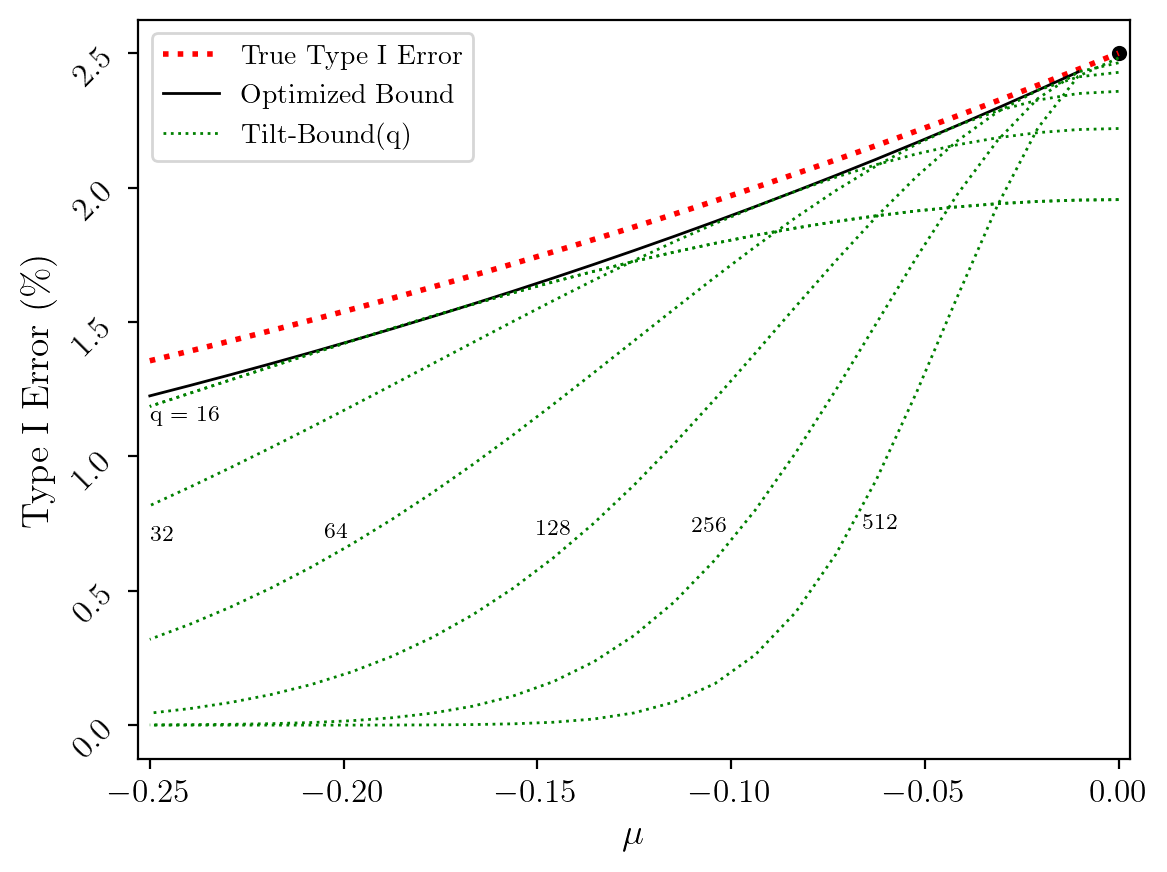

In [219]:
#Next, let's do the backward plot!
vlist = np.linspace(0,.25,25)
x = np.linspace(-.25, 0, 1000)
z = ztest(delta=0.05, x = x, nsims=int(1e5))
mu_dense10 = np.linspace(-.25, 0, 100)
pow_dense10 = true_err(mu_dense10)
#Plotting the true function in red
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=2, label = "True Type I Error")
vadjust = - vlist

#Now plotting the optimal
qsolveback = jamesbound.BackwardQCPSolver(scale=1)
optqsback = qsolve.solve(vlist,.025)
optboundback = jamesbound.tilt_bound_bwd(optqsback,1,vlist,.025)
plt.plot(vadjust,optboundback,"k",linewidth=1, label = "Optimized Bound")

#Plotting for 6 different choices of q, ranging from 2^4 to 2^9
for i in range(len(qlist)):
    output = jamesbound.tilt_bound_bwd(qlist[i],1,vlist,.025)
    filter = output < .03
    plt.plot(vadjust[filter], output[filter], "g:", linewidth=1)
plt.plot(vadjust[filter], output[filter], "g", linestyle = ":",linewidth=1, label = 'Tilt-Bound(q)')

leg = plt.legend(loc='upper left',fontsize = 10)

plt.scatter(0,true_err(0),color = 'k', marker = 'o', s = 20)
#plt.axvline(0, color='k', linestyle='--',linewidth = '.25')
#plt.axhline(.025, color='k', linestyle='-.',linewidth = '.5')
plt.xlim([-0.253, 0.003])
yticks = np.linspace(0, 0.025, 6)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xlabel('$\mu$')
plt.ylabel('Type I Error ($\%$)')

plt.text(-.066,.0073,'512',fontsize = 8)
plt.text(-.110,.0072,'256',fontsize = 8)
plt.text(-.15,.0071,'128',fontsize = 8)
plt.text(-.205,.006975,'64',fontsize = 8)
plt.text(-.25,.00688,'32',fontsize = 8)
plt.text(-.25,.0113,'q = 16',fontsize = 8)

plt.savefig('greens_down.pdf', bbox_inches='tight')


#Next Figure: Showing the critical value of lambda which gives a proper backsolve? Actually, nevermind, let's just drop that figure!!
We'll say clearly that we require to tune for a target TIE of at most

In [24]:
optboundback[len(optboundback)]

DeviceArray(0.01224855, dtype=float64)

In [25]:
#The critical order statistic is:
orderstat = int(optboundback[len(optboundback)] * (nsims+1))
critstats = np.quantile(samples,q = (nsims - orderstat)/nsims,axis = -1)
print(critstats)
1 - scipy.stats.norm.cdf(max(critstats))

[1.48837849 2.00722552]


0.02236282759022523

Now we'll average the above calculation, and present the resulting average Type I Error achieved!

In [274]:
def tune_TIE_sample(npt, nsim, backwards_bound):
    mu = np.linspace(-1, 0, 2 * npt + 1)[1::2]
    sample = mu[:, None] + np.random.normal(0, 1, size=(1, nsim))
    orderstat = int(backwards_bound * (nsim+1))
    critstats = np.quantile(sample,q = (nsim - orderstat)/nsim,axis = -1)
    return(1 - scipy.stats.norm.cdf(max(critstats)))

def average_result(npt,nsim,nreps):
    results = np.zeros(nreps)
    for i in range(nreps):
        qsolveback = jamesbound.BackwardQCPSolver(scale=1)
        optqsback = qsolve.solve(.5/npt,.025)
        optboundback = jamesbound.tilt_bound_bwd(optqsback,1,.5/npt,.025)
        results[i]=tune_TIE_sample(npt, nsim,optboundback)
    return np.mean(results)

average_result(10,10000,10)

def integrand(x, params, v):
    return scipy.stats.norm.cdf( -v + scipy.stats.norm.ppf(x))*scipy.stats.beta.pdf(x,params[0],params[1]) 

def beta_integrated_TIE(npt,nsims):
    qback = jamesbound.BackwardQCPSolver(scale=1)
    qback = qsolve.solve(1/(2*npt),.025)
    optboundback = jamesbound.tilt_bound_bwd(qback,1,1/(2*npt),.025)
    orderstat = int(optboundback * (nsims+1))
    betaparams = [orderstat, nsims+1-orderstat]
    return scipy.integrate.quad(lambda x: integrand(x,betaparams,1/(2*npt)),0,1)

In [292]:
npts = [5, 10, 20, 40, 80]
nsims = [100,300,1000,3000,10000]

def vectorize_over_nsim(npt,nsims):
    output = np.zeros(len(nsims))
    for i in range(len(nsims)):
        output[i] = beta_integrated_TIE(npt,nsims[i])[0]
    return output

#vectorize_over_nsim(npts[2], nsims, 10)

In [287]:
#Investigation of the kink in the plot below for TIE for npts = 20
#i = 2
#temp = vectorize_over_nsim(npts[i],nsims)
#beta_integrated_TIE(20,300)
#beta_integrated_TIE(20,1000)
#npt = 20
#nsims = 1000
#qback = jamesbound.BackwardQCPSolver(scale=1)
#qback = qsolve.solve(1/(2*npt),.025)
#optboundback = jamesbound.tilt_bound_bwd(qback,1,1/(2*npt),.025)
#orderstat = int(optboundback * (nsims+1))
#betaparams = [orderstat, nsims+1-orderstat]
#orderstat

23

In [288]:
#beta_integrated_TIE(20,300)
#beta_integrated_TIE(20,1000)
#npt = 20
#nsims = 300
#qback = jamesbound.BackwardQCPSolver(scale=1)
#qback = qsolve.solve(1/(2*npt),.025)
#optboundback = jamesbound.tilt_bound_bwd(qback,1,1/(2*npt),.025)
#orderstat = int(optboundback * (nsims+1))
#betaparams = [orderstat, nsims+1-orderstat]
#orderstat

7

In [290]:
#23/1000

0.023

In [289]:
#7/300
#This makes sense! The calibration discretization favors N=300 the way things line up for this value of N

0.023333333333333334

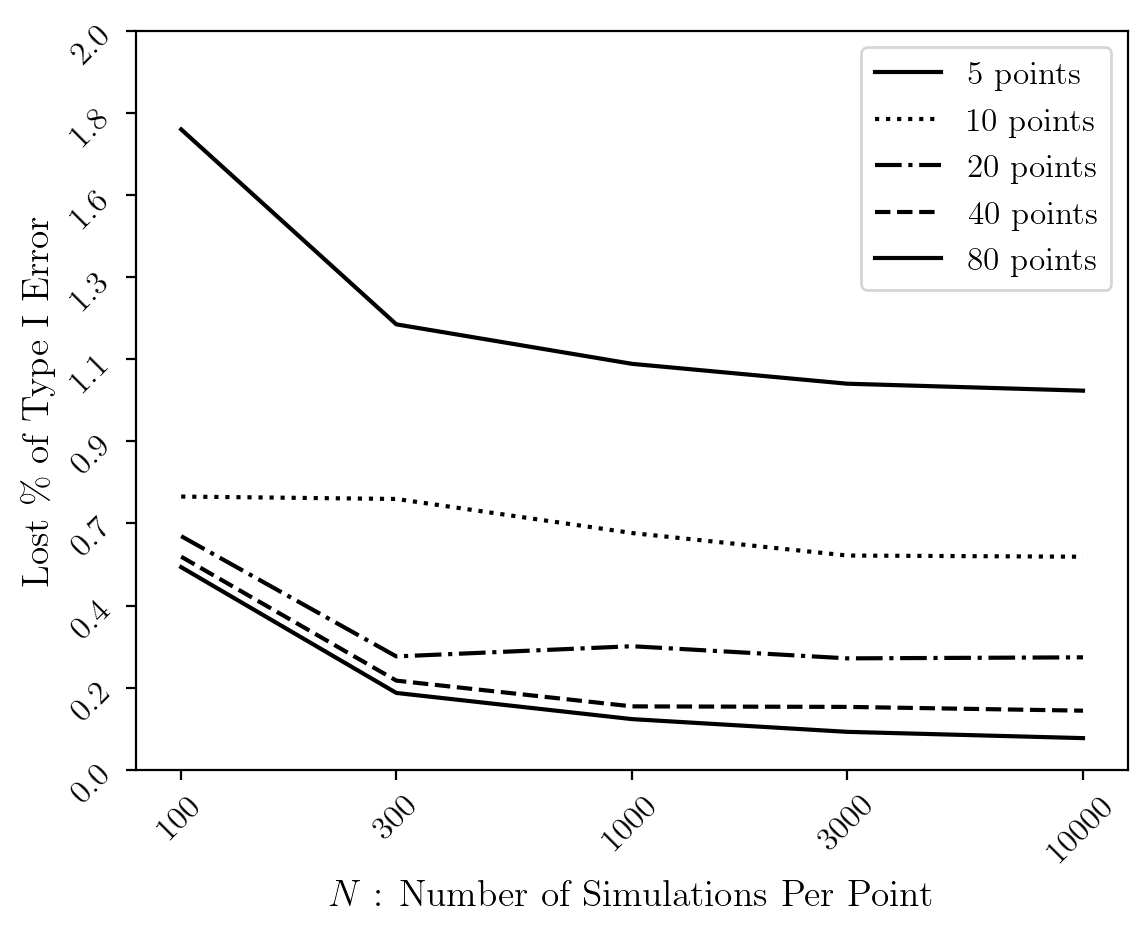

In [293]:
styles = ['k-', 'k:', 'k-.', 'k--', 'k-', 'k:']
for i in range(len(npts)):
    temp = vectorize_over_nsim(npts[i],nsims)
    plt.plot(np.log(nsims), 0.025 - temp, styles[i],label = f'{npts[i]:.0f} points')
plt.legend(fontsize=12)
plt.ylabel('Lost \% of Type I Error')
yticks = np.linspace(0, 0.02, 10)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.01f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xticks(np.log(nsims), rotation=45)
#plt.gca().set_xticklabels([f'{x:.1e}' for x in nsims])
plt.gca().set_xticklabels(nsims)
plt.xlabel('$N$ : Number of Simulations Per Point')
plt.savefig("z-test-cost.pdf", bbox_inches="tight")
plt.show()

In [27]:
mu = -np.linspace(0,1,npts+1)
mu

array([-0. , -0.5, -1. ])

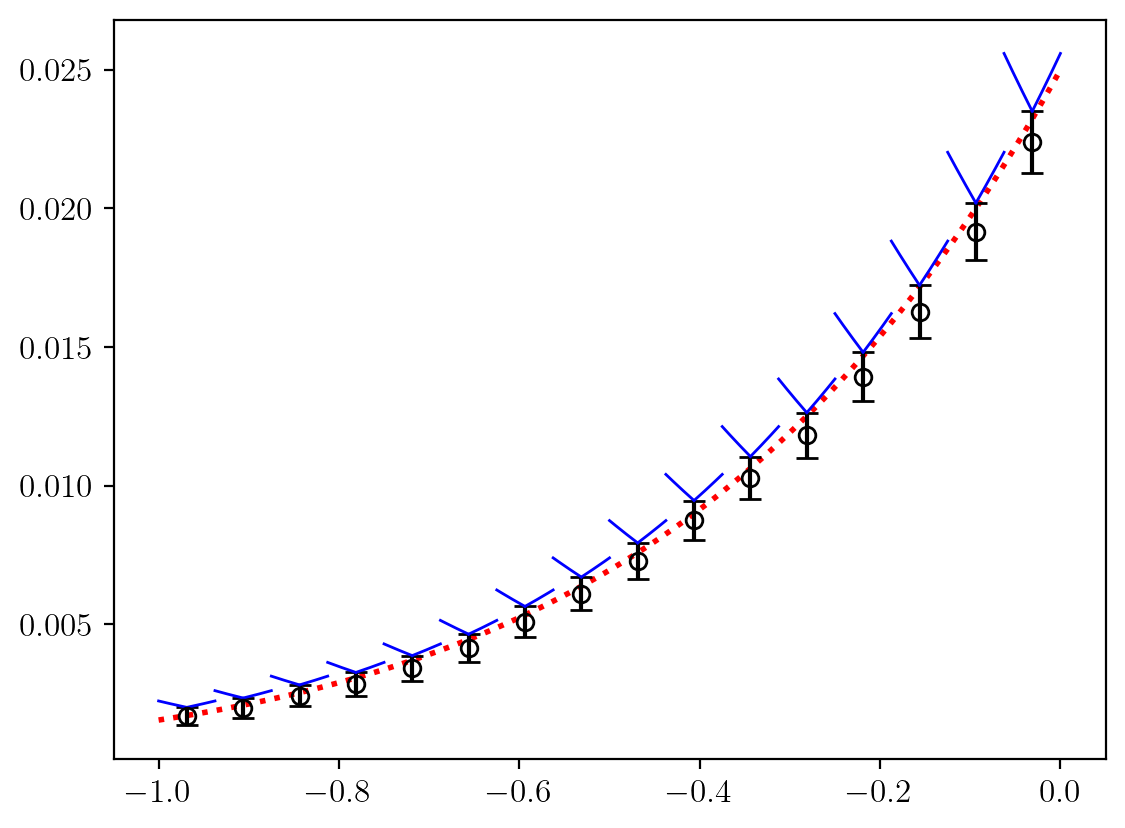

In [28]:
#Last figure: Bound which gives the optimized-q bound on top of clopper-pearson
npts = 16
nsims = 100000
mu = np.linspace(a, b, 2 * npts + 1)[1::2]
samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
typeI_sum = np.sum(samples > z_thresh, axis=-1)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est

vlist = np.linspace(0, 1/(2 *npts), 250)
x = np.linspace(-.1, 0, 1000)
z = ztest(delta=0.05, x = x, nsims=int(1e5))
mu_dense10 = np.linspace(-1, 0, 100)
pow_dense10 = true_err(mu_dense10)
#Plotting the true function in red
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=2)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)

for i in range(npts):
    ystart = typeI_est[i] + typeI_CI[i]
    qsolve = jamesbound.ForwardQCPSolver(scale=1)
    optqs = qsolve.solve(vlist,ystart)
    optbound = jamesbound.tilt_bound_fwd(optqs,1,vlist,ystart)
    vadjust = vlist + np.repeat(mu[i],len(vlist))
    #Now plotting the optimal
    plt.plot(vadjust,optbound,"b",linewidth=1)

for i in range(npts):
    ystart = typeI_est[i] + typeI_CI[i]
    qsolve = jamesbound.ForwardQCPSolver(scale=1)
    optqs = qsolve.solve(vlist,ystart)
    optbound = jamesbound.tilt_bound_fwd(optqs,1,vlist,ystart)
    vadjust = -vlist + np.repeat(mu[i],len(vlist))
    #Now plotting the optimal
    plt.plot(vadjust,optbound,"b",linewidth=1)



## re-using from previously:
#samples = np.random.normal(mu[:,None], 1, size=(mu.shape[0], nsims,))
#reject = samples > z_thresh
#typeI_sum = np.sum(reject, axis=-1)
#typeI_est = typeI_sum / nsims
#typeI_est, true_err(mu)
#typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est


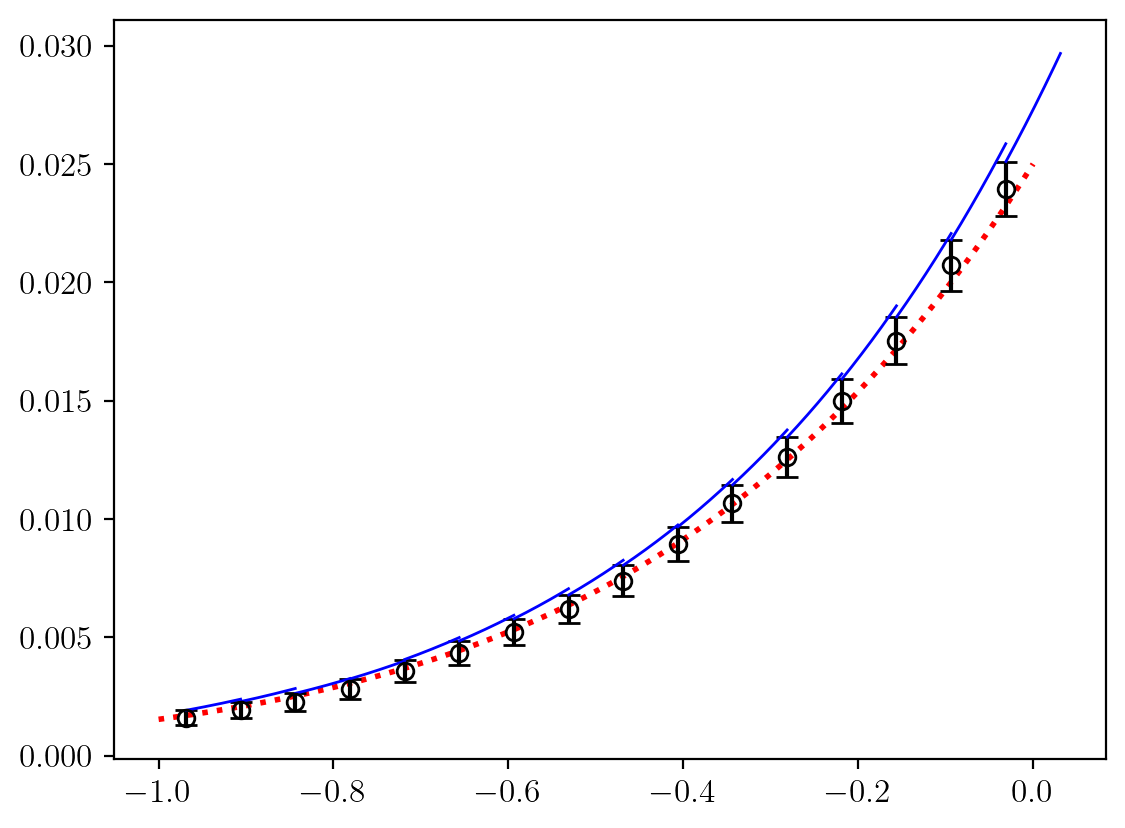

In [29]:
#Last figure: Bound which gives the optimized-q bound on top of clopper-pearson
npts = 16
nsims = 100000
mu = np.linspace(a, b, 2 * npts + 1)[1::2]
samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
typeI_sum = np.sum(samples > z_thresh, axis=-1)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est

vlist = np.linspace(0, 2/(2 *npts), 250)
x = np.linspace(-.1, 0, 1000)
z = ztest(delta=0.05, x = x, nsims=int(1e5))
mu_dense10 = np.linspace(-1, 0, 100)
pow_dense10 = true_err(mu_dense10)
#Plotting the true function in red
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=2)
plt.errorbar(
    mu,
    typeI_est,
    yerr=typeI_CI,
    ecolor="k",
    fmt="o",
    capsize=4,
    markeredgecolor="k",
    markerfacecolor="none",
)

for i in range(npts):
    ystart = typeI_est[i] + typeI_CI[i]
    qsolve = jamesbound.ForwardQCPSolver(scale=1)
    optqs = qsolve.solve(vlist,ystart)
    optbound = jamesbound.tilt_bound_fwd(optqs,1,vlist,ystart)
    vadjust = vlist + np.repeat(mu[i],len(vlist))
    #Now plotting the optimal
    plt.plot(vadjust,optbound,"b",linewidth=1)

#for i in range(npts):
#    ystart = typeI_est[i] + typeI_CI[i]
#    qsolve = jamesbound.ForwardQCPSolver(scale=1)
#    optqs = qsolve.solve(vlist,ystart)
#    optbound = jamesbound.tilt_bound_fwd(optqs,1,vlist,ystart)
#    vadjust = -vlist + np.repeat(mu[i],len(vlist))
#    #Now plotting the optimal
#    plt.plot(vadjust,optbound,"b",linewidth=1)


#testtttt
## re-using from previously:
#samples = np.random.normal(mu[:,None], 1, size=(mu.shape[0], nsims,))
#reject = samples > z_thresh
#typeI_sum = np.sum(reject, axis=-1)
#typeI_est = typeI_sum / nsims
#typeI_est, true_err(mu)
#typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est

DeviceArray([0.00075779, 0.00136659], dtype=float64)

DeviceArray([0.00075779, 0.00136659], dtype=float64)

In [200]:
#The result is a threshold of 2.007 instead of 1.96!
# What is the resulting Type I Error at the end of the day, though?
# 2.2%

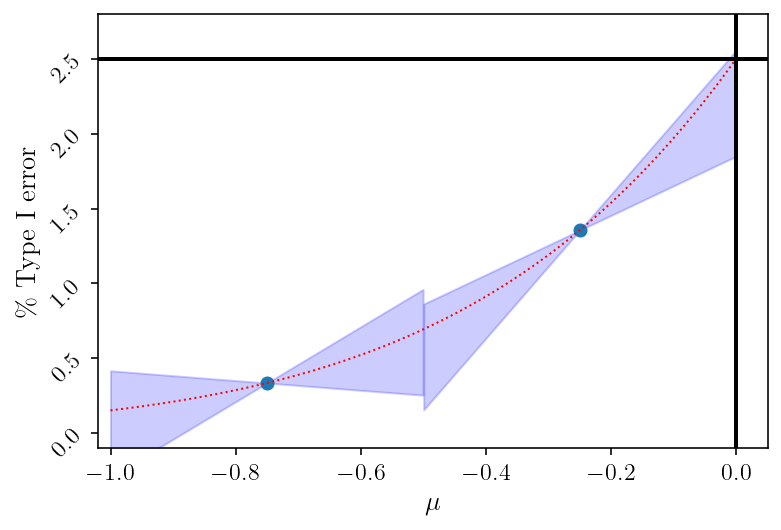

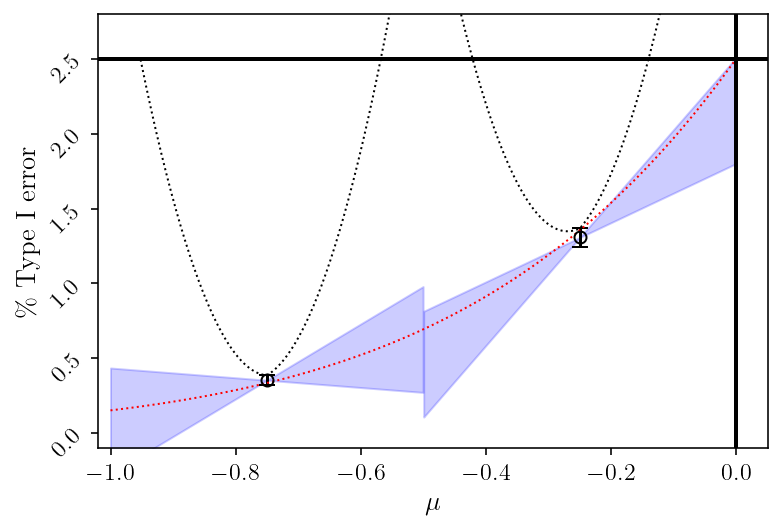

In [25]:
#Now let's extend ONLY to the right, and see what happens


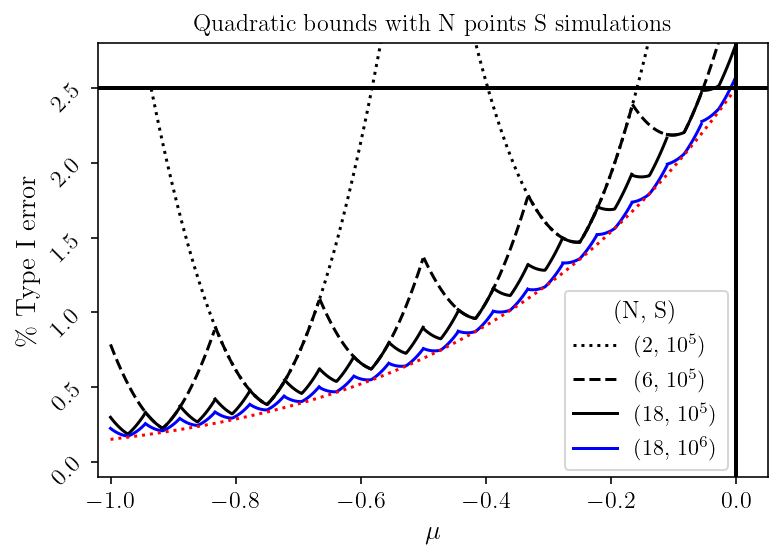

In [26]:
def fig3(**kwargs):
    npts = [2, 6, 18, 18]
    nsims = [int(1e5), int(1e5), int(1e5), int(1e6)]
    linestyle = ["k:", "k--", "k-", "b-"]
    x = np.linspace(-1, 0, 1000)
    for j in range(len(npts)):
        P = npts[j]
        label = f"({P}, $10^5$)" if j < 3 else f"({P}, $10^6$)"
        S = nsims[j]
        z = ztest(npts = P, nsims=S, delta=0.01, x = x, seed=13)

        filter = (x > -0.8) | (z['full_max_bound'] < 0.025)
        for i in range(len(z['mu'])):
            select = (z['closest_mu_idx'] == i) & filter
            plt.plot(x[select], z['full_max_bound'][select], linestyle[j], label=label if i == 0 else None)
    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10)
    plt.plot(mu_dense10, pow_dense10, "r:")
    set_domain(**kwargs)
    plt.legend(loc=(0.697, 0.018), fontsize=11, title="(N, S)", title_fontsize=12)


fig3()
plt.title("Quadratic bounds with N points S simulations", fontsize=12)
plt.show()


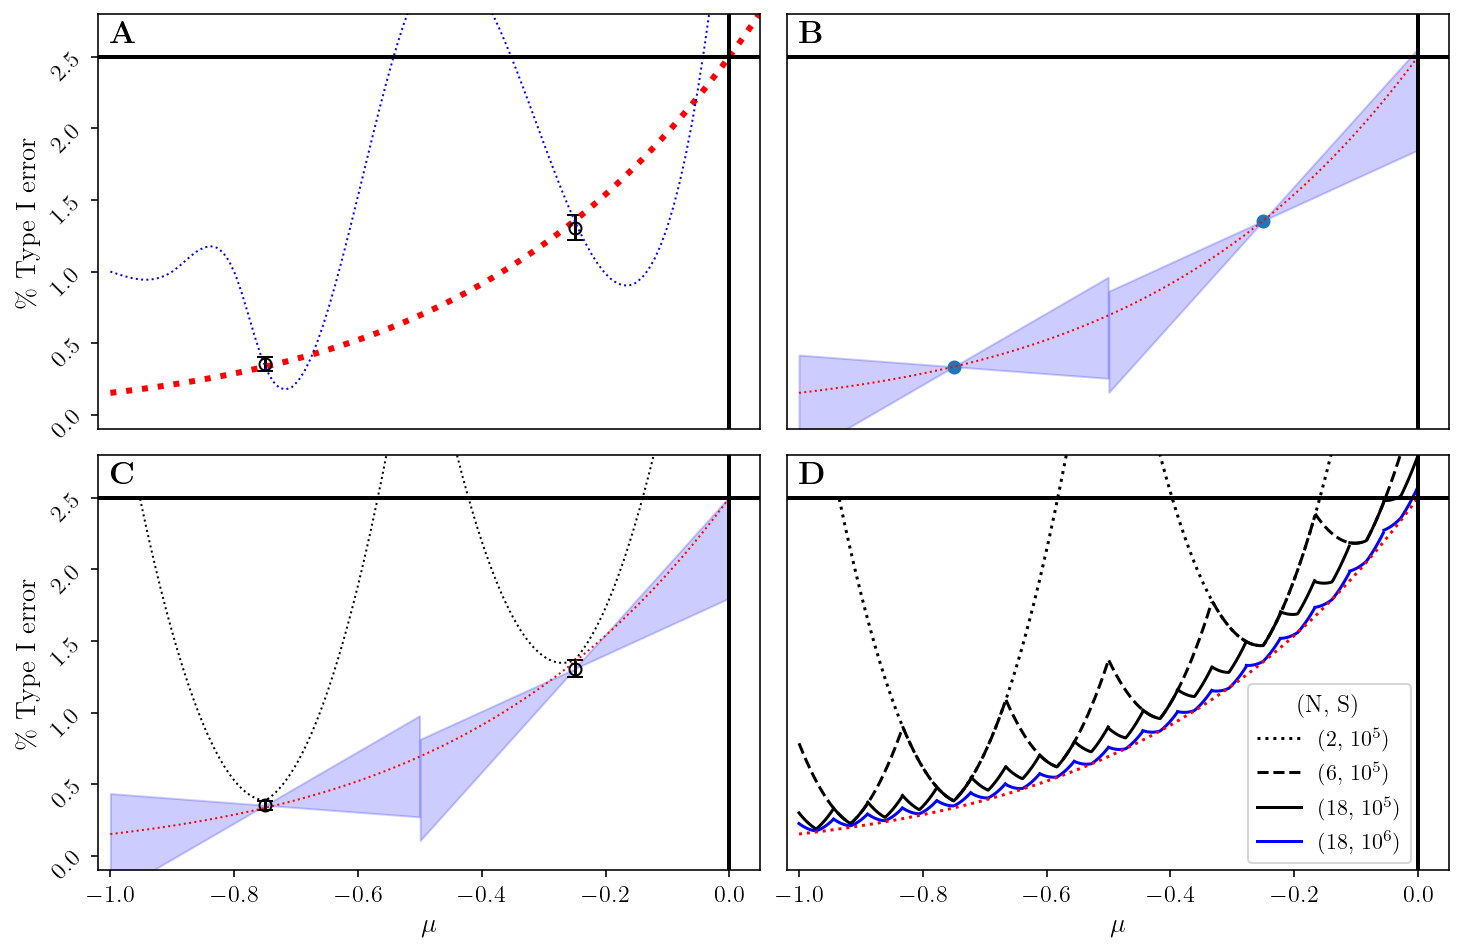

In [27]:
%matplotlib inline
import matplotlib.patches as patches

ratio = 8.5 / 5.5
h = 6.5
plt.figure(figsize=(ratio * h, h), constrained_layout=True)
plt.subplot(2, 2, 1)
fig1(True, skipx=True)
plt.text(-1, 0.026, "$\mathbf{A}$", fontsize=16)
plt.subplot(2, 2, 2)
fig2(False, False, skipx=True, skipy=True)
plt.text(-1, 0.026, "$\mathbf{B}$", fontsize=16)
plt.subplot(2, 2, 3)
fig2(True, True)
plt.text(-1, 0.026, "$\mathbf{C}$", fontsize=16)
plt.subplot(2, 2, 4)
fig3(skipy=True)
t = plt.text(-1, 0.026, "$\mathbf{D}$", fontsize=16)
plt.savefig("ztest-four-panels.pdf", bbox_inches="tight")
plt.show()


In [28]:
z_thresh_default = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu, z_thresh: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)

def ztest(npts=2, a=-1, b=0, z_thresh=z_thresh_default, delta=0.01, nsims=10000, seed=9, x=None):
    np.random.seed(seed)

    mu = np.linspace(a, b, 2 * npts + 1)[1::2]
    samples = mu[:, None] + np.random.normal(0, 1, size=(1, nsims))
    typeI_sum = np.sum(samples > z_thresh, axis=-1)
    typeI_est = typeI_sum / nsims
    grad_est = np.sum((samples > z_thresh) * (samples - mu[:, None]), axis=-1) / nsims

    typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
    grad_bound = np.sqrt((1 / delta - 1) / nsims)
    hess_bound = 1.0
    
    if x is None:
        x = mu
    closest_mu_idx = np.abs(x[:, None] - mu[None, :]).argmin(axis=-1)

    v = x - mu[closest_mu_idx]
    grad_bounds = np.array([
        v * (grad_est[closest_mu_idx] + grad_bound),
        v * (grad_est[closest_mu_idx] - grad_bound)
    ])
    max_1st_order = np.max(grad_bounds, axis=0)
    min_1st_order = np.min(grad_bounds, axis=0)

    # NOTE: min_2nd_order = -max_2nd_order
    max_2nd_order = 0.5 * hess_bound * (x - mu[closest_mu_idx]) ** 2

    full_max_bound = (typeI_est + typeI_CI)[closest_mu_idx] + max_1st_order + max_2nd_order
    full_min_bound = (typeI_est - typeI_CI)[closest_mu_idx] + min_1st_order - max_2nd_order
    
    return dict(
        mu=mu, 
        typeI_true=true_err(mu, z_thresh), 
        typeI_est=typeI_est, 
        typeI_CI=typeI_CI, 
        grad_est=grad_est, 
        grad_bound=grad_bound, 
        hess_bound=hess_bound,
        closest_mu_idx=closest_mu_idx,
        max_1st_order=max_1st_order,
        min_1st_order=min_1st_order,
        max_2nd_order=max_2nd_order,
        full_max_bound=full_max_bound,
        full_min_bound=full_min_bound
    )

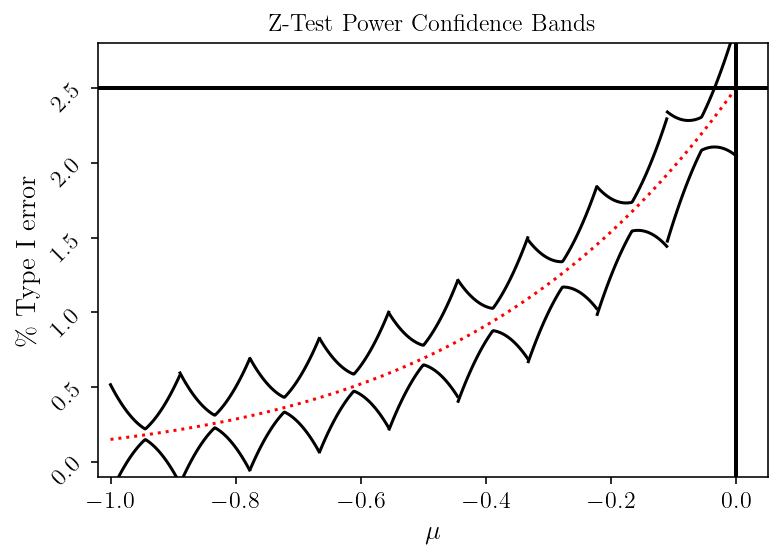

In [29]:
def fig5(z_thresh, seed, **kwargs):
    linestyle = ["k-"]
    x = np.linspace(-1, 0, 1000)
    z = ztest(z_thresh=z_thresh, npts = 9, nsims=int(1e5), delta=0.01, x = x, seed=seed)

    for i in range(len(z['mu'])):
        select = z['closest_mu_idx'] == i
        plt.plot(x[select], z['full_max_bound'][select], 'k-')
        plt.plot(x[select], z['full_min_bound'][select], 'k-')
    mu_dense10 = np.linspace(-1, 0, 100)
    pow_dense10 = true_err(mu_dense10, z_thresh)
    plt.plot(mu_dense10, pow_dense10, "r:")
    set_domain(**kwargs)


fig5(1.96, 12)
plt.title("Z-Test Power Confidence Bands", fontsize=12)
plt.savefig("power-ztest.pdf", bbox_inches="tight")
plt.show()

# fig5(2.04, 12)
# plt.title("CSE-Tuned Z-Test Power Confidence Bands", fontsize=12)
# plt.savefig("tuned-ztest.pdf", bbox_inches="tight")
# plt.show()

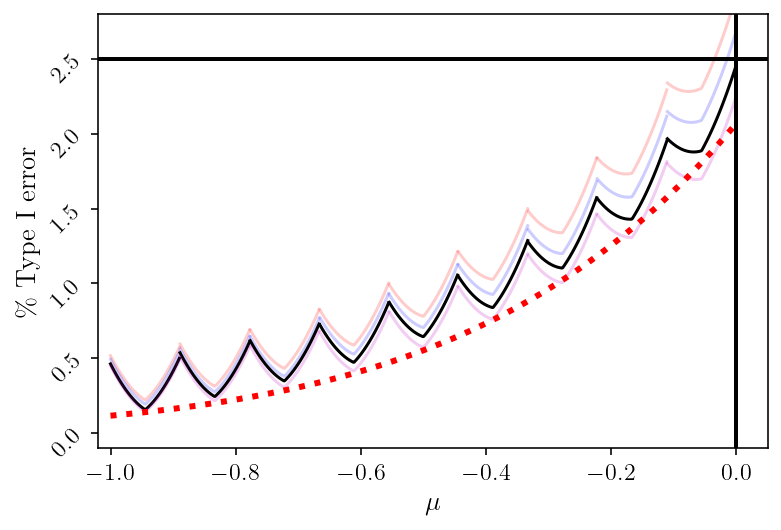

In [30]:
linestyle = ["k-"]
x = np.linspace(-1, 0, 1000)
for j, z_thresh in enumerate(np.linspace(1.96, 2.08, 4)):
    pick = z_thresh == 2.04
    z = ztest(z_thresh=z_thresh, npts=9, nsims=int(1e5), delta=0.01, x=x, seed=12)

    for i in range(len(z["mu"])):
        select = z["closest_mu_idx"] == i
        plt.plot(
            x[select],
            z["full_max_bound"][select],
            alpha=1.0 if pick else 0.2,
            color="k" if pick else ["r", "b", "g", "m"][j],
        )
        # skip the lower bound
        # plt.plot(x[select], z['full_min_bound'][select], alpha = 1.0 if pick else 0.3, color = "k" if pick else None)
mu_dense10 = np.linspace(-1, 0, 100)
pow_dense10 = true_err(mu_dense10, 2.04)
plt.plot(mu_dense10, pow_dense10, "r:", linewidth=3)

set_domain()
plt.savefig("tuned-ztest.pdf", bbox_inches="tight")
plt.show()

In [33]:
mu_dense10[-1], pow_dense10[-1]

(0.0, DeviceArray(0.02067516, dtype=float64))

In [95]:
import numpy as np
x = np.array([0.0])
npts = [5, 10, 20, 40, 80]
nsims = [2500, 10000, 40000, 90000, 160000, 250000, 360000]
bound0 = np.empty((len(npts), len(nsims)))
for i, P in enumerate(npts):
    for j, S in enumerate(nsims):
        z = ztest(z_thresh=1.96, npts = int(P), nsims=int(S), delta=0.01, x = x, seed=12)
        bound0[i, j] = z['full_max_bound'][0]

In [102]:
z = ztest(z_thresh=1.96, npts = 200, nsims=int(1e6), delta=0.01, x = x, seed=12)
z['full_max_bound'][0] - 0.025

0.00020564090532306997

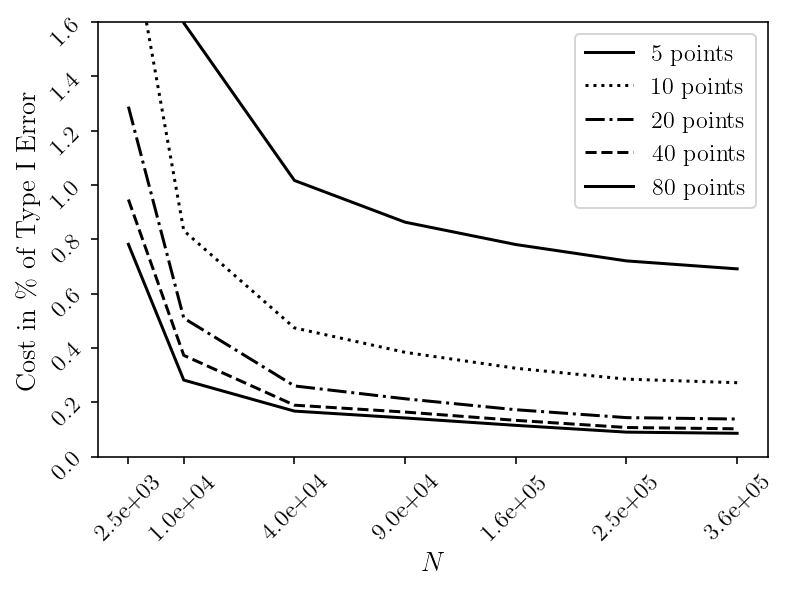

In [105]:
styles = ['k-', 'k:', 'k-.', 'k--', 'k-', 'k:']
for i in range(len(npts)):
    plt.plot(np.sqrt(nsims), bound0[i, :] - 0.025, styles[i], label = f'{npts[i]:.0f} points')
plt.legend(fontsize=12)
plt.ylim([0, 0.016])
plt.ylabel('Cost in \% of Type I Error')
yticks = np.linspace(0, 0.016, 9)
plt.yticks(
    yticks,
    labels=[f"{(yv * 100):.1f}" for yv in yticks],
    rotation=45,
    ha="right",
)
plt.xticks(np.sqrt(nsims), rotation=45)
plt.gca().set_xticklabels([f'{x:.1e}' for x in nsims])
plt.xlabel('$N$')
plt.savefig("z-test-cost.pdf", bbox_inches="tight")
plt.show()